In [10]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import ndcg_score

In [11]:
TEST_PATH = "subset_ratings.csv"
test_df   = pd.read_csv(TEST_PATH)
test_df   = test_df[test_df.movieId.notna()]

In [12]:
def precision_recall_at_k(pred_dict, df, k=10):
    hit = rec = rel = 0
    for uid, grp in df.groupby("userId"):
        if uid not in pred_dict:
            continue
        true_items = set(grp.movieId)
        pred_items = pred_dict[uid][:k]
        hits       = len(true_items & set(pred_items))
        hit += hits;  rec += k;  rel += len(true_items)
    return hit / rec if rec else 0, hit / rel if rel else 0

In [13]:
def ndcg_at_k(pred_dict, df, k=10):
    y_true, y_score = [], []
    for uid, grp in df.groupby("userId"):
        if uid not in pred_dict:
            continue
        true_items = set(grp.movieId)
        preds      = (pred_dict[uid] + [-1] * k)[:k]      # pad/truncate
        rel        = [1 if m in true_items else 0 for m in preds]
        y_score.append(rel)
        y_true.append(sorted(rel, reverse=True))
    return ndcg_score(y_true, y_score) if y_true else 0.0

In [14]:
MODEL_FILES = {
    "ALS"          : "predictions/als_top10_subset.json",
    "CBF"          : "predictions/cbf_top10_subset.json",
    "KNN"          : "predictions/knn_top10_subset.json",
    "Hybrid"       : "predictions/hybrid_top10_subset.json",
    "HybridUserCF" : "predictions/hybrid_userCF_top10_subset.json",
}

def load_predictions(path):
    """Return {userId:int -> [movieId:int, …]} for a json file."""
    with open(path, encoding="utf-8") as fp:
        raw = json.load(fp)

    preds = {}
    for uid, movie_list in raw.items():
        try:
            uid_int = int(uid)                        # user-id to int
        except ValueError:
            continue
        # ▼ NEW: coerce every predicted movieId to int as well
        preds[uid_int] = [int(m) for m in movie_list if str(m).isdigit()]

    return preds

                P@10    R@10  NDCG@10
Model                                
ALS           0.0028  0.0001   0.0171
CBF           0.0275  0.0013   0.1026
Hybrid        0.2079  0.0098   0.4567
HybridUserCF  0.3154  0.0095   0.5650
KNN           0.0101  0.0005   0.0439


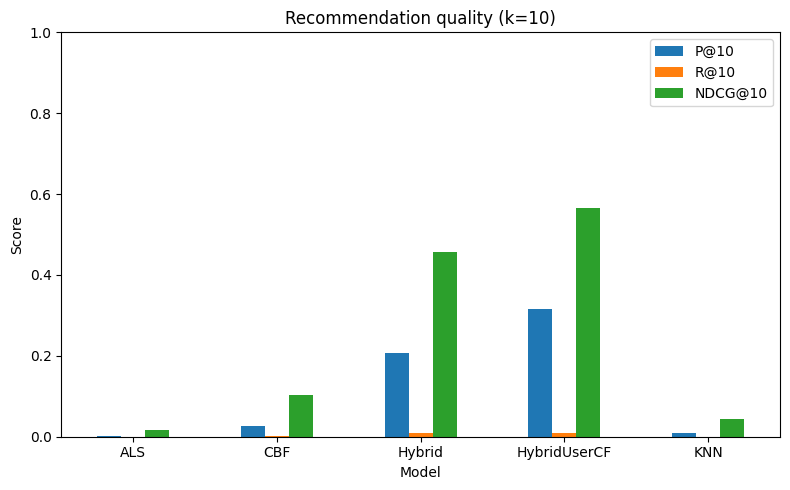

In [15]:
# --------------------------------------------------------------------
K = 10
rows = []
for model, file in MODEL_FILES.items():
    preds = load_predictions(file)
    p, r  = precision_recall_at_k(preds, test_df, K)
    n     = ndcg_at_k(preds, test_df, K)
    rows.append({"Model": model,
                 f"P@{K}": round(p, 4),
                 f"R@{K}": round(r, 4),
                 f"NDCG@{K}": round(n, 4)})

metrics = (pd.DataFrame(rows)
             .set_index("Model")
             .sort_index())

print(metrics)

ax = metrics.plot(kind="bar", figsize=(8, 5))
ax.set_title(f"Recommendation quality (k={K})")
ax.set_ylim(0, 1)
ax.set_ylabel("Score")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()